# Butteryfly Species Identification Using CNN

In [1]:
from data_loading import load_testing_data, get_key
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


%load_ext autoreload
%autoreload 2

## Loading and manipulating the data

In [2]:
labels, images, images_seg, labels_dict = load_testing_data()

The images in this dataset were 224x224. I was unable to use a GPU, so training a model on images of that size would have taken a prohibitavily long time. I found that scaling the images down to 1/3 of their orignial resolution provided a good balance between speed and accurracy. 

In [3]:
scaled_images_seg = []
scaled_images = []
for img in images_seg:
    scaled_img_seg = cv.resize(img, None, fx= 0.3, fy= 0.3, interpolation= cv.INTER_LINEAR)
    scaled_images_seg.append(scaled_img_seg)

for img in images:
    scaled_img = cv.resize(img, None, fx= 0.3, fy= 0.3, interpolation= cv.INTER_LINEAR)
    scaled_images.append(scaled_img)



In [5]:
print("Original Size: ", img.shape)
print("Scaled Size: ", scaled_img.shape)

Original Size:  (224, 224, 3)
Scaled Size:  (67, 67, 3)


### Displaying Sample Images

Since we want this CNN to be able to idenify butterfly species, we removed the background of the images. The code that accomplished this was sourced from an example notebook on Kaggle. [1] It uses OpenCV's grabCut method to separate the butterfly from the background. This allows the CNN to focus on the specifics of the butterfly and not any unintentional similarities found in background of the images. Samples of the original images and segmented images are found below.

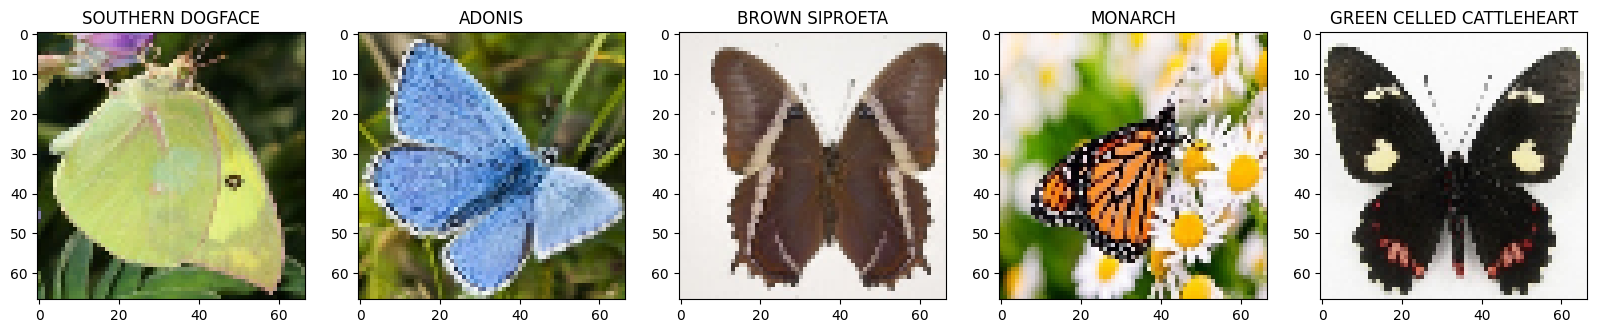

In [6]:
plt.figure(figsize=(20,5))                # Create a figure of size 20x5

# Create subplots of one row and three columns: subplot(nrows, ncols, index, **kwargs)
# For documentation, see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
plt.subplot(1, 5, 1),plt.imshow(cv.cvtColor(scaled_images[0], cv.COLOR_BGR2RGB)),plt.title(get_key(0, labels_dict))
plt.subplot(1, 5, 2),plt.imshow(cv.cvtColor(scaled_images[1], cv.COLOR_BGR2RGB)),plt.title(get_key(1, labels_dict))
plt.subplot(1, 5, 3),plt.imshow(cv.cvtColor(scaled_images[2], cv.COLOR_BGR2RGB)),plt.title(get_key(2, labels_dict))
plt.subplot(1, 5, 4),plt.imshow(cv.cvtColor(scaled_images[3], cv.COLOR_BGR2RGB)),plt.title(get_key(3, labels_dict))
plt.subplot(1, 5, 5),plt.imshow(cv.cvtColor(scaled_images[4], cv.COLOR_BGR2RGB)),plt.title(get_key(4, labels_dict))
plt.show()

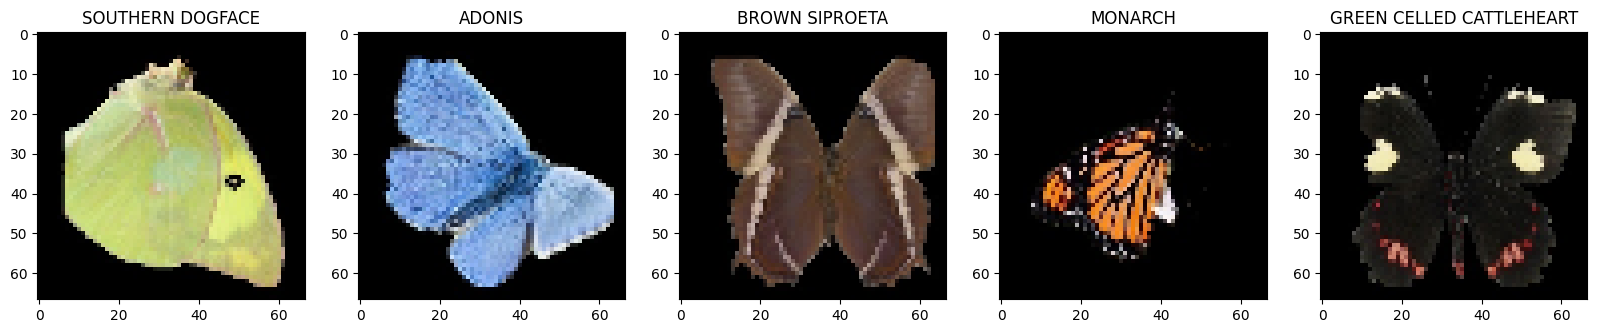

In [7]:
plt.figure(figsize=(20,5))                # Create a figure of size 20x5

# Create subplots of one row and three columns: subplot(nrows, ncols, index, **kwargs)
# For documentation, see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
plt.subplot(1, 5, 1),plt.imshow(cv.cvtColor(scaled_images_seg[0], cv.COLOR_BGR2RGB)),plt.title(get_key(0, labels_dict))
plt.subplot(1, 5, 2),plt.imshow(cv.cvtColor(scaled_images_seg[1], cv.COLOR_BGR2RGB)),plt.title(get_key(1, labels_dict))
plt.subplot(1, 5, 3),plt.imshow(cv.cvtColor(scaled_images_seg[2], cv.COLOR_BGR2RGB)),plt.title(get_key(2, labels_dict))
plt.subplot(1, 5, 4),plt.imshow(cv.cvtColor(scaled_images_seg[3], cv.COLOR_BGR2RGB)),plt.title(get_key(3, labels_dict))
plt.subplot(1, 5, 5),plt.imshow(cv.cvtColor(scaled_images_seg[4], cv.COLOR_BGR2RGB)),plt.title(get_key(4, labels_dict))
plt.show()

While training this model, we struggled to get a decent level of accuracy. There was only an average of 86 images per species in this dataset, which is limited. One trick we tried to improve accuracy was data augmentation. The application we tried was simple: rotating the butterflies 90 degrees clockwise and adding those images to the dataset. The hope was that the increased number of samples would increase accuracy. This effort was somewhat successful - the accuracy of the model increased from 56% without the augmented data to 62% with the augmented data.

In [16]:

index = 0
labels_seg = labels
while index < 6499:
    rotated_img = cv.rotate(scaled_images_seg[index], cv.ROTATE_90_CLOCKWISE)
    scaled_images_seg.append(rotated_img)
    label = labels[index]
    labels_seg.append(label)
    index += 1


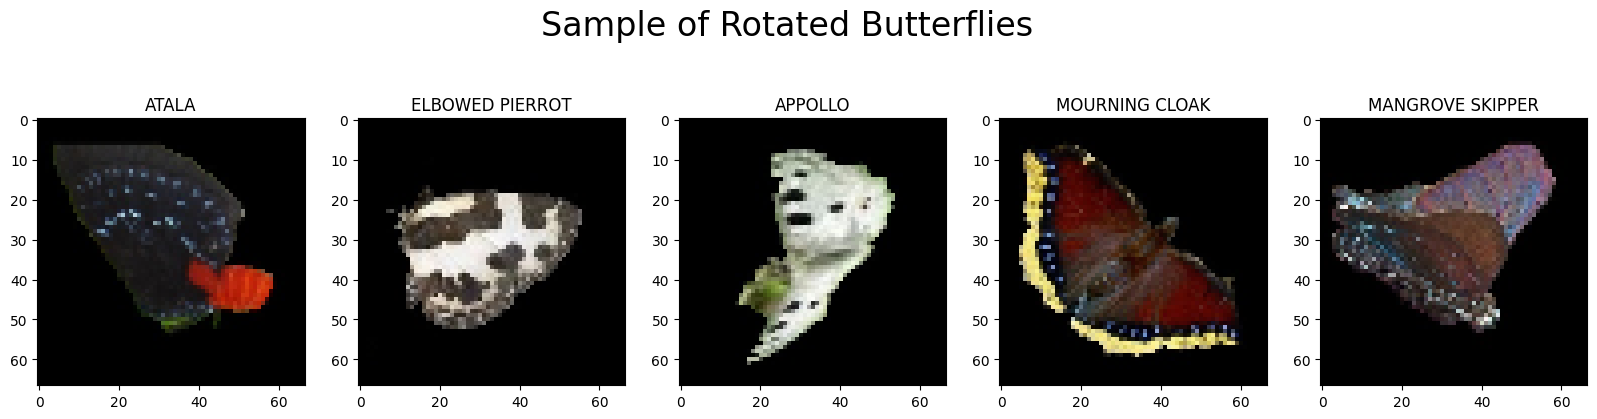

In [28]:
plt.figure(figsize=(20,5)), plt.suptitle("Sample of Rotated Butterflies", fontsize=24)

# Create subplots of one row and three columns: subplot(nrows, ncols, index, **kwargs)
# For documentation, see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
plt.subplot(1, 5, 1),plt.imshow(cv.cvtColor(scaled_images_seg[-1], cv.COLOR_BGR2RGB)),plt.title(get_key(labels[-1][0], labels_dict))
plt.subplot(1, 5, 2),plt.imshow(cv.cvtColor(scaled_images_seg[-2], cv.COLOR_BGR2RGB)),plt.title(get_key(labels[-2][0], labels_dict))
plt.subplot(1, 5, 3),plt.imshow(cv.cvtColor(scaled_images_seg[-3], cv.COLOR_BGR2RGB)),plt.title(get_key(labels[-3][0], labels_dict))
plt.subplot(1, 5, 4),plt.imshow(cv.cvtColor(scaled_images_seg[-4], cv.COLOR_BGR2RGB)),plt.title(get_key(labels[-4][0], labels_dict))
plt.subplot(1, 5, 5),plt.imshow(cv.cvtColor(scaled_images_seg[-5], cv.COLOR_BGR2RGB)),plt.title(get_key(labels[-5][0], labels_dict))
plt.show()

### Separating Training and Testing Data

The data is split into 70% training data and 30% testing data using sklearn's train_test_split fuction. It is then normalized and expanded to fit the dimensions expected by the model.

In [47]:
images_train, images_test, labels_train, labels_test = train_test_split(scaled_images_seg, labels, test_size=0.3)
images_train = (np.expand_dims(images_train, axis=-1)/255.).astype(np.float32)
labels_train = np.array((labels_train)).astype(np.int64)
images_test = (np.expand_dims(images_test, axis=-1)/255.).astype(np.float32)
labels_test = np.array((labels_test)).astype(np.int64)

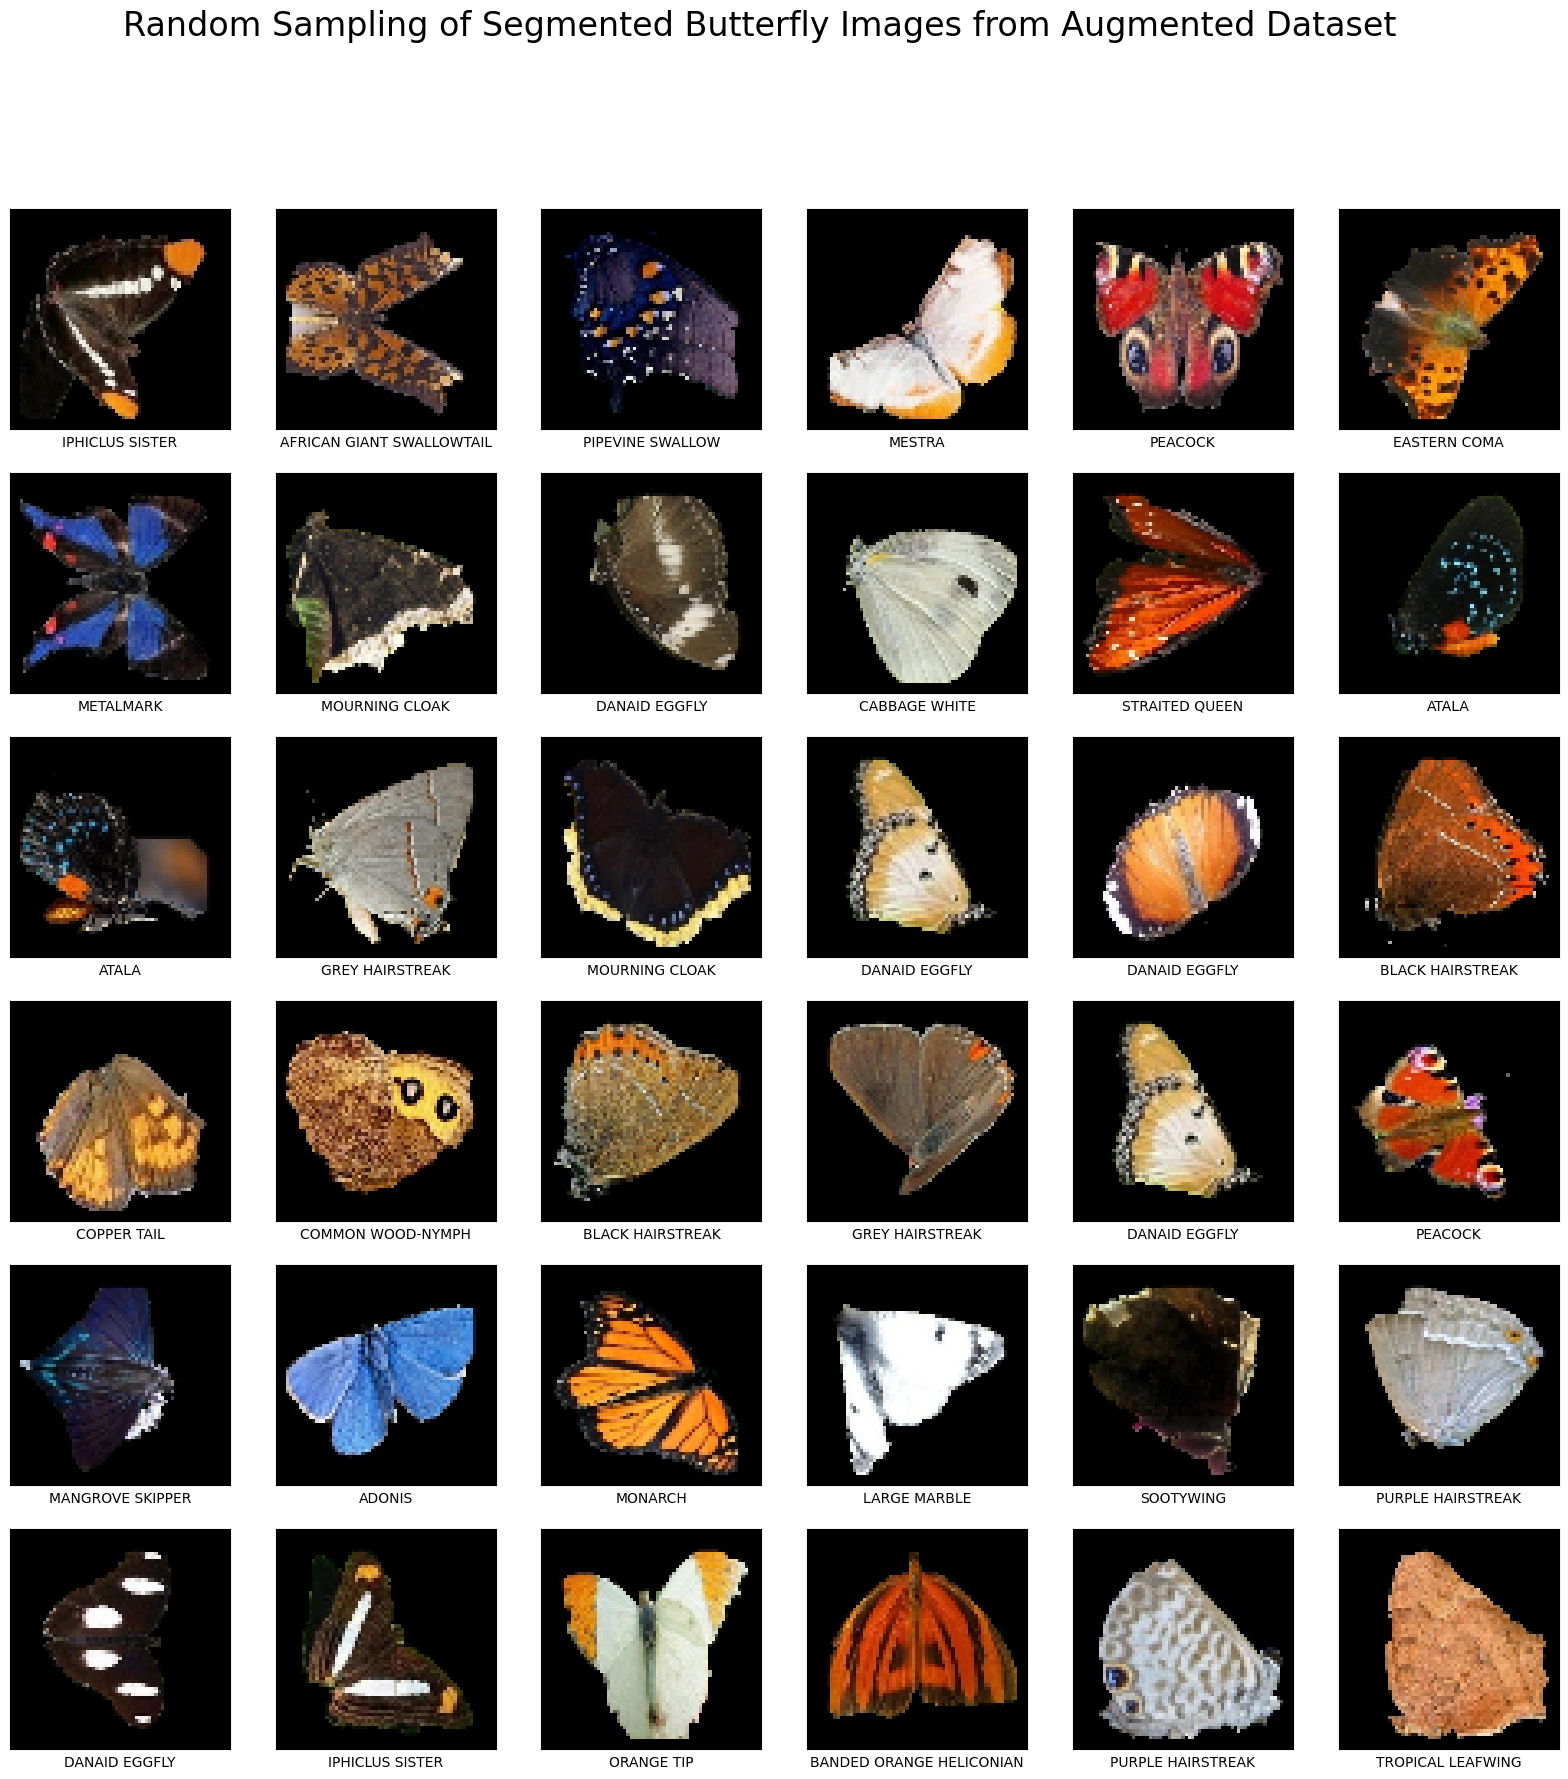

In [37]:
plt.figure(figsize=(20,20)), plt.suptitle("Random Sampling of Segmented Butterfly Images from Augmented Dataset", fontsize=24)
random_inds = np.random.choice(1000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(cv.cvtColor(np.squeeze(images_train[image_ind]),cv.COLOR_BGR2RGB), cmap=plt.cm.binary)
    plt.xlabel(get_key(labels_train[image_ind], labels_dict))

## Building the Model

The network architecture of our model is as follows:
- INPUT: holds the raw image data of the detected size. In our case, [67x67x3].
- CONV 1: a convolutional layer of 50 filters with kernel size [3x3], resulting in an output volume of [65x65x50].
- RELU 1: applies the activation function. The output volume is unchanged.
- POOL 1: applies a pooling layer of size [2x2], resulting in an outpt volume of [32x32x50].
- CONV 2: a secon convolutional layer with 24 filters and kernel size [5x5]. The output volume is [28x28x24].
- RELU 2: applies the activation function. The output volume remains unchanged.
- POOL 2: applies another pooling layer of size [3x3], retulsing in an output volume of [9x9x24].
- FL: Flattens our [9x9x24] matrix into a vector of dimension 1944.
- FC 1: Reduces out 1944 units to 90.
- DROPOUT: Selects 30% of the neurons at random to drop out to prevent overfitting. The output volume is unchanged.
- FC 2: Computes the class scores, producing an output volume of [1x1x75], where the 75 numbers correspond to the class that image belongs to. 
- The softmax activation function converts the resulting numbers into probabilitys between 0 and 1 that the image belongs to each class.

In [48]:
def build_cnn_model():
    cnn_model = tf.keras.models.Sequential()

    # Define the first convolutional layer
    cnn_model.add(layers.Conv2D(filters=50, kernel_size=(3,3), activation='relu', input_shape=(images_train[0].shape[0:3])))


    # Define the first max pooling layer
    cnn_model.add(layers.MaxPool2D(pool_size=(2,2)))

    # Define the second convolutional layer
    cnn_model.add(layers.Conv2D(filters=24, kernel_size=(5,5), activation='relu'))

    # Define the second max pooling layer
    cnn_model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Flatten the volume into a vector
    cnn_model.add(layers.Flatten())
    
    # A hidden fully connected layer
    cnn_model.add(layers.Dense(90, activation='relu'))

    # Add dropout layer
    cnn_model.add(layers.Dropout(0.3))

    # Define the last Dense layer to output the classification probabilities. 
    # Pay attention to the activation needed a probability output
    cnn_model.add(layers.Dense(75, activation='softmax'))
    
    return cnn_model
  
cnn_model = build_cnn_model()

# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 65, 65, 50)        1400      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 50)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 24)        30024     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 9, 9, 24)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1944)              0         
                                                                 
 dense_4 (Dense)             (None, 90)               

In [49]:
#Define the compile operation with your optimizer and learning rate of choice
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 55
EPOCHS = 15

# Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.
history = cnn_model.fit(images_train, labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                        validation_data=(images_test, labels_test))

Epoch 1/15
174/174 [==============================] - 34s 186ms/step - loss: 3.8178 - accuracy: 0.0901 - val_loss: 3.0111 - val_accuracy: 0.2410
Epoch 2/15
174/174 [==============================] - 30s 175ms/step - loss: 2.8988 - accuracy: 0.2443 - val_loss: 2.4521 - val_accuracy: 0.3729
Epoch 3/15
174/174 [==============================] - 30s 172ms/step - loss: 2.4489 - accuracy: 0.3398 - val_loss: 2.0975 - val_accuracy: 0.4388
Epoch 4/15
174/174 [==============================] - 30s 171ms/step - loss: 2.1278 - accuracy: 0.4153 - val_loss: 1.9941 - val_accuracy: 0.4696
Epoch 5/15
174/174 [==============================] - 29s 169ms/step - loss: 1.9495 - accuracy: 0.4537 - val_loss: 1.8504 - val_accuracy: 0.4947
Epoch 6/15
174/174 [==============================] - 30s 170ms/step - loss: 1.7860 - accuracy: 0.4942 - val_loss: 1.7464 - val_accuracy: 0.5201
Epoch 7/15
174/174 [==============================] - 30s 170ms/step - loss: 1.6437 - accuracy: 0.5270 - val_loss: 1.6240 - val_ac

Text(0.5, 0.98, 'Training History')

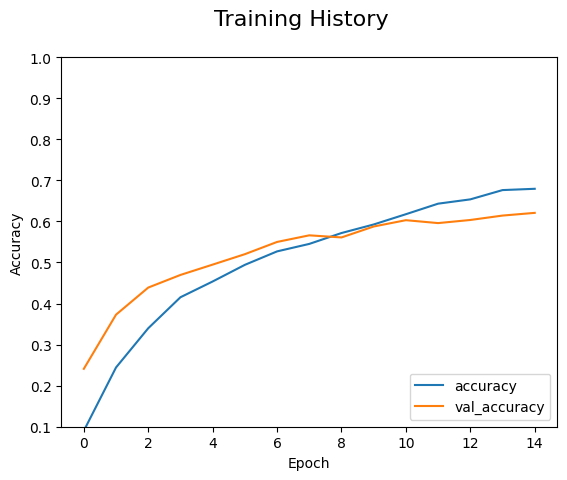

In [53]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.suptitle("Training History", fontsize=16)

This model gets about 62% accuracy on the testing data.

In [60]:
# Evaluating the model on the testing data
test_loss, test_acc = cnn_model.evaluate(images_test, labels_test)

print('Test accuracy:', test_acc)

128/128 [==============================] - 3s 26ms/step - loss: 1.4172 - accuracy: 0.6208
Test accuracy: 0.6207570433616638


## Other methods for evaluating the model

The model can then be saved after training.

In [54]:
model_name = "models4"
cnn_model.save("./cnn/" + model_name)

INFO:tensorflow:Assets written to: ./cnn/models4\assets


INFO:tensorflow:Assets written to: ./cnn/models4\assets


Specify which model to load, then load the model.

In [57]:
model_name = "models4"
model = keras.models.load_model("./cnn/" + model_name)

Use the model to predict the species of the butterflies in the test images.

In [58]:
predictions = model.predict(images_test)
predicted_labels = []

for prediction in predictions:
    index = np.argmax(prediction)
    label = get_key(index, labels_dict)
    predicted_labels.append(label)

128/128 [==============================] - 3s 23ms/step


The following shows the classification report for the predictions made by this model. 

In [67]:
from sklearn.metrics import classification_report
labels_test_string = []
for label in labels_test:
    string_label = get_key(label, labels_dict)
    labels_test_string.append(string_label)

species = np.unique(predicted_labels)
print(classification_report(labels_test_string, predicted_labels))

                           precision    recall  f1-score   support

                   ADONIS       0.86      0.74      0.79        57
AFRICAN GIANT SWALLOWTAIL       0.82      0.73      0.78        64
           AMERICAN SNOOT       0.57      0.47      0.51        45
                    AN 88       0.84      0.90      0.87        51
                  APPOLLO       0.74      0.65      0.69        52
                    ATALA       0.73      0.90      0.81        49
 BANDED ORANGE HELICONIAN       0.85      0.52      0.65        65
           BANDED PEACOCK       0.87      0.62      0.72        55
            BECKERS WHITE       0.25      0.38      0.30        48
         BLACK HAIRSTREAK       0.61      0.72      0.66        58
              BLUE MORPHO       0.64      0.46      0.53        50
        BLUE SPOTTED CROW       0.45      0.49      0.47        51
           BROWN SIPROETA       0.69      0.71      0.70        68
            CABBAGE WHITE       0.67      0.70      0.69     